# EDA

We have a [dataset](https://lms.skillfactory.ru/assets/courseware/v1/425d6864db937e4ebabc972e581769ab/asset-v1:Skillfactory+DST-12+11MAR2020+type@asset+block/stud_math.csv) with information about student's live and studying conditions and the final scores of the math exam.

Our goal is process the dataset and finds parameters which impact on the final score the most.

This information will be used to predict the results of the math exam in the future.


## Load dataset and all required modules

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import ttest_ind

df = pd.read_csv('stud_math.csv')

## Common function

In [2]:
figsize = (10,10)

def preview_numeric_column(column, dataframe):
    #df = df if df is None else other_dataframe
    median = column.median()
    perc25 = column.quantile(0.25)
    perc75 = column.quantile(0.75)
    IQR = perc75-perc25
    left=perc25 - 1.5*IQR
    right=perc75 + 1.5*IQR
    print('Left:', left, 'Median:', median, 'Right:', right)
    bins = 4*len(column.value_counts())
    column.hist(bins=bins, label = column.name, figsize=figsize)
    col = dataframe.loc[column.between(left,right)][column.name]
    col.hist(bins=bins, label = 'w/o outliers', figsize=figsize)
    plt.legend()
    plt.title("Column "+column.name)
    
    
    return (left, median, right)

In [3]:
def get_boxplot(column, dataframe):
    fig, ax = plt.subplots(figsize = (6, 6))
    sns.boxplot(x=column, y='score', 
                data=dataframe.loc[:, ['score', column]],
                ax=ax)
    ax.set_title('Boxplot for ' + column)
    plt.show()

In [4]:
def is_stat_dif(column, dataframe, d = 0.05):
    
    cols = dataframe.loc[:, column].value_counts().index
    combinations_all = list(combinations(cols, 2))
    alpha = d/len(combinations_all)
    for comb in combinations_all:
        a = dataframe.loc[dataframe.loc[:, column] == comb[0], 'score']
        b = dataframe.loc[dataframe.loc[:, column] == comb[1], 'score']
        ttest = ttest_ind(a, b)
        if ttest.pvalue <= alpha:
            return True

## Dataset owerview

First, we have to get `df` size and check if pandas already removed nulls from the dataset.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   school               395 non-null    object 
 1   sex                  395 non-null    object 
 2   age                  395 non-null    int64  
 3   address              378 non-null    object 
 4   famsize              368 non-null    object 
 5   Pstatus              350 non-null    object 
 6   Medu                 392 non-null    float64
 7   Fedu                 371 non-null    float64
 8   Mjob                 376 non-null    object 
 9   Fjob                 359 non-null    object 
 10  reason               378 non-null    object 
 11  guardian             364 non-null    object 
 12  traveltime           367 non-null    float64
 13  studytime            388 non-null    float64
 14  failures             373 non-null    float64
 15  schoolsup            386 non-null    obj

Column `studytime, granular` is redundant. Rows with Nan value in score column is also useles.

In [6]:
df = df.drop(['studytime, granular'], axis=1)
df = df[~df.score.isna()]

There are many columns(address, Medu, etc) with reduced amount of non-null rows(less than 395).




## Data validation and clean up

We have predefined sets of values for many columns(like sex, edu, etc):

In [7]:
allowed_values = {
    'sex': ['F', 'M'],
    'address': ['U', 'R'],
    'famsize': ['LE3', 'GT3'],
    'Pstatus': ['T', 'A'],
    'Medu': [0, 1.0, 2.0, 3.0, 4.0],
    'Fedu': [0, 1.0, 2.0, 3.0, 4.0],
    'Mjob': ['teacher', 'health', 'services', 'at_home', 'other'],
    'Fjob': ['teacher', 'health', 'services', 'at_home', 'other'],
    'reason': ['home', 'reputation', 'course', 'other'],
    'guardian': ['mother', 'father', 'other'],
    'traveltime': [1.0, 2.0, 3.0, 4.0],
    'studytime': [1.0, 2.0, 3.0, 4.0],
    'failures': [0, 1.0, 2.0, 3.0],
    'schoolsup': ['yes', 'no'],
    'famsup': ['yes', 'no'],
    'paid': ['yes', 'no'],
    'activities': ['yes', 'no'],
    'nursery': ['yes', 'no'],
    'higher': ['yes', 'no'],
    'internet': ['yes', 'no'],
    'romantic': ['yes', 'no'],
    'famrel': [1.0, 2.0, 3.0, 4.0, 5.0],
    'freetime': [1.0, 2.0, 3.0, 4.0, 5.0],
    'goout': [1.0, 2.0, 3.0, 4.0, 5.0],
    'health': [1.0, 2.0, 3.0, 4.0, 5.0]
}

Let's verify that data frame values are matched to the allowed values sets.

In [8]:
for column, values in allowed_values.items():
    a_values = set(values)
    df_values= set(df[column].value_counts().index)
    if df_values != a_values:
        print("Column", column, "contains not allowed values:", df_values - a_values)

Column Fedu contains not allowed values: {40.0}
Column famrel contains not allowed values: {-1.0}


Cleaning up Fedu and famrel from bad values:

In [9]:
df = df[df.famrel.isin(allowed_values['famrel'])]
df = df[df.Fedu.isin(allowed_values['Fedu'])]

## Nominal and numeric columns

We split columns to numeric and nominal for convenience and automatic processing.

In [10]:
numeric_columns = ['age', 'absences', 'score']
nominal_columns = set(df.columns) - set(numeric_columns)

## Numeric columns overview and adjustments

### Age



Left: 13.0 Median: 17.0 Right: 21.0


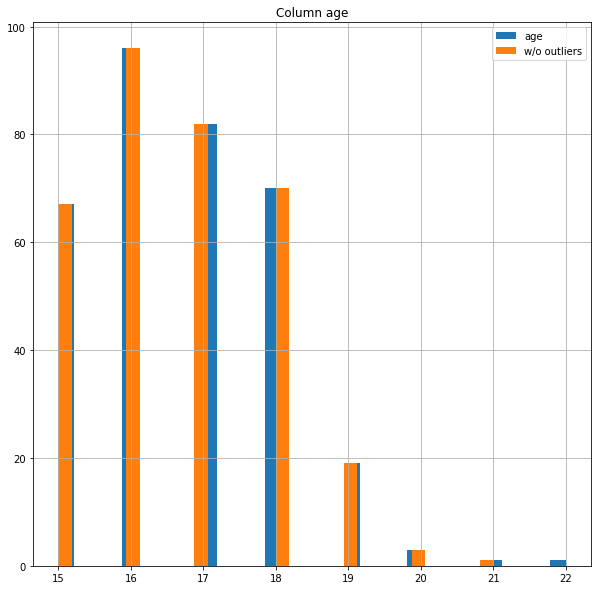

In [11]:
_ = preview_numeric_column(df.age, df)

Values in the `age` columns are looking good. We won't cut "outliers".

### Absences

Left: -12.0 Median: 4.0 Right: 20.0


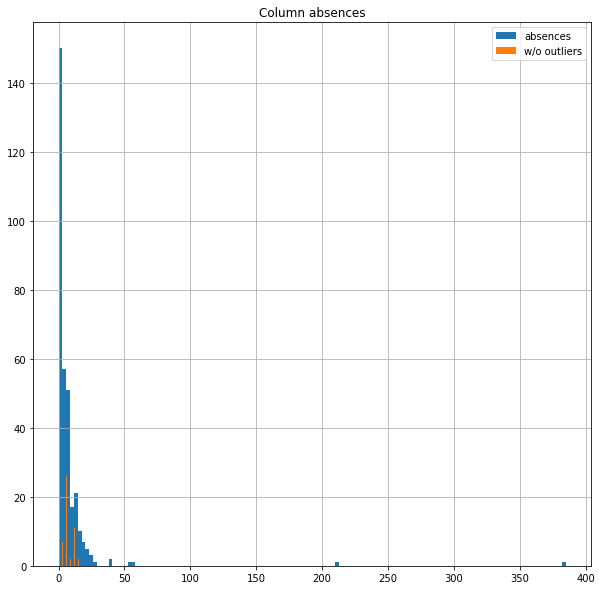

In [12]:
_ = preview_numeric_column(df.absences, df)

There are outliers detected. Limit amount of absense to 50.

Left: -12.0 Median: 4.0 Right: 20.0


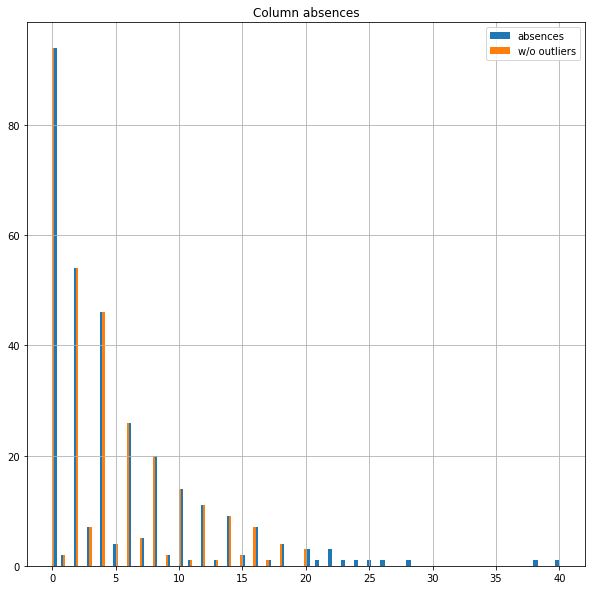

In [13]:
absences50 = df[df.absences < 50]
_ = preview_numeric_column(absences50.absences, absences50)

The right tail is behaves like normal distribution. Limit absences with 30. 

In [14]:
df = df.loc[df.absences <= 30]

### Score

Left: 15.0 Median: 55.0 Right: 95.0


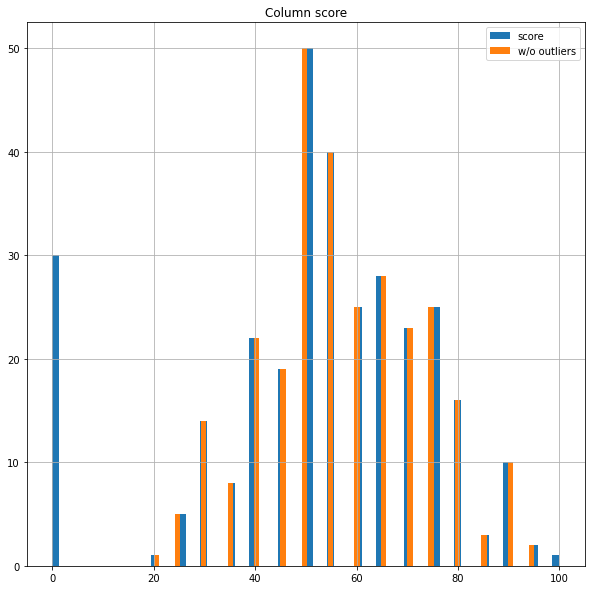

In [15]:
_ = preview_numeric_column(df.score,  df)

Zero score values on the left are outliers, 100 scores on the right are not. 

Left: 20.0 Median: 55.0 Right: 100.0


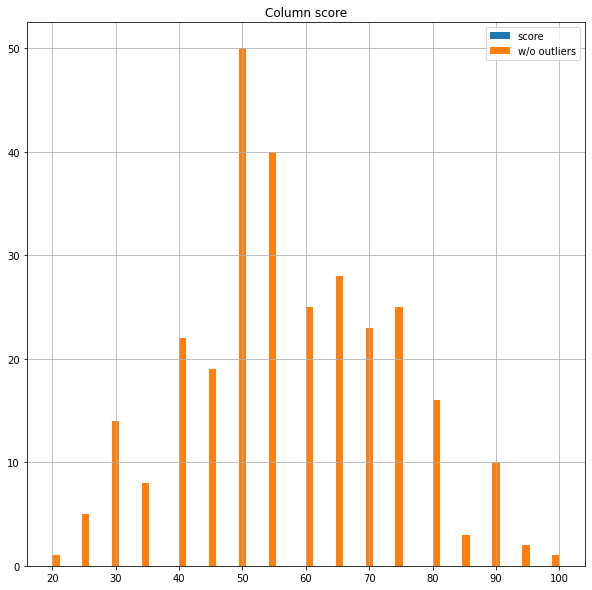

In [16]:
df = df[df.score>1]
_ = preview_numeric_column(df.score, df)

## Noninal variable which represents continious spaces

There are set of columns which represents time, feelings etc, but splited by 5 or less buckets.
Such values should have normal distribution or close to normal.

### Travel time

Left: -0.5 Median: 1.0 Right: 3.5


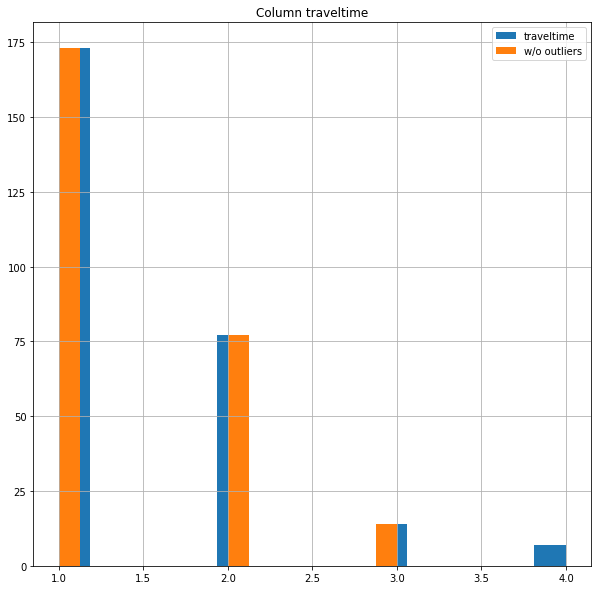

In [17]:
_ = preview_numeric_column(df.traveltime, df)

### Study time

Left: -0.5 Median: 2.0 Right: 3.5


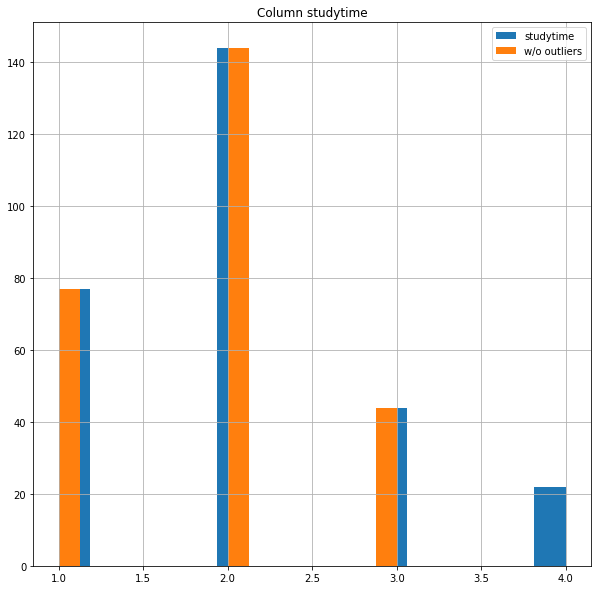

In [18]:
_ = preview_numeric_column(df.studytime, df)

### Family relations

Left: 2.5 Median: 4.0 Right: 6.5


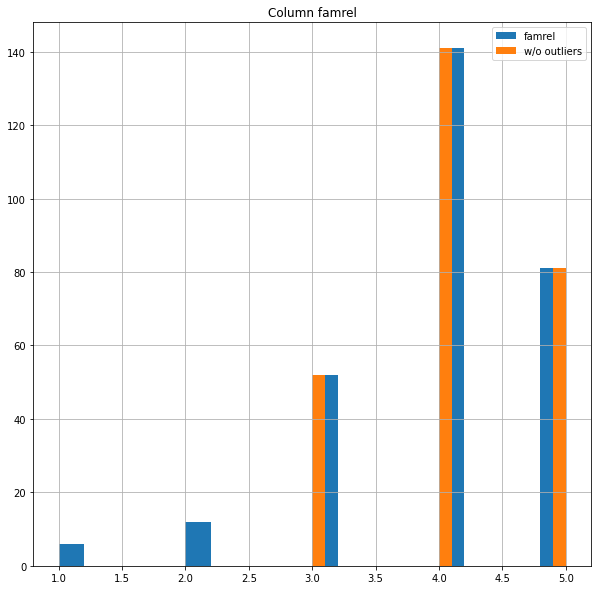

In [19]:
_ = preview_numeric_column(df.famrel, df)

All good.

### Free time

Left: 1.5 Median: 3.0 Right: 5.5


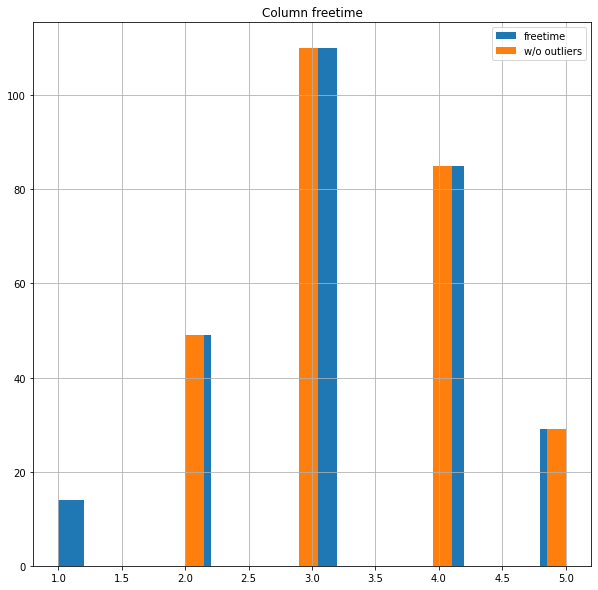

In [20]:
_ = preview_numeric_column(df.freetime, df)

### Go out

Left: -1.0 Median: 3.0 Right: 7.0


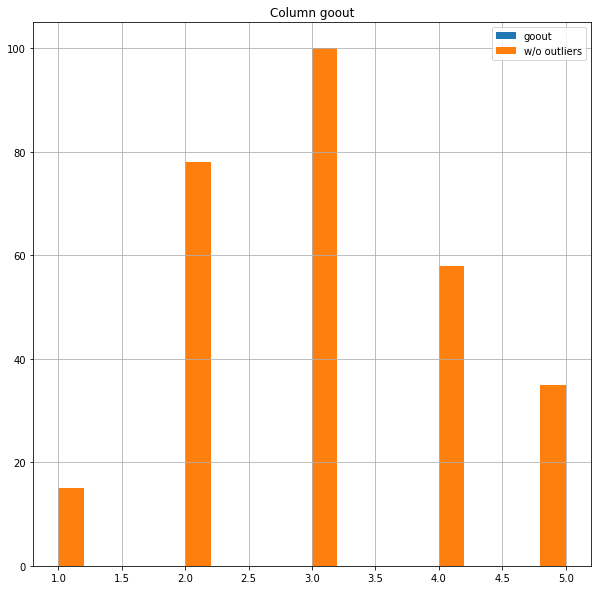

In [21]:
_ = preview_numeric_column(df.goout, df)

### Health

Left: -0.625 Median: 3.5 Right: 8.375


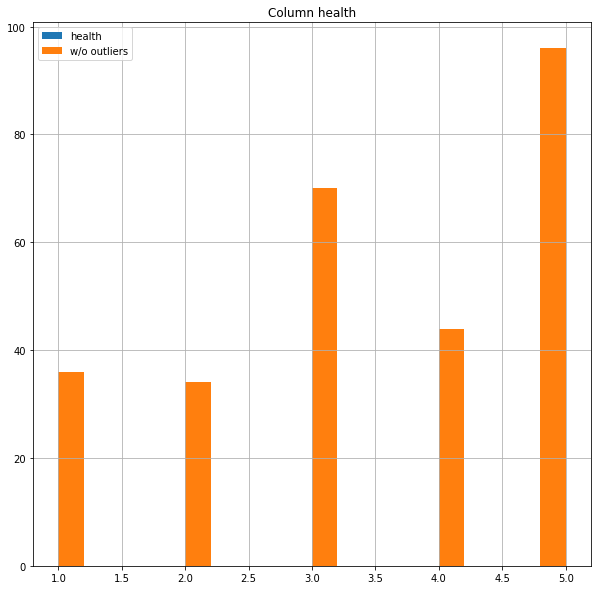

In [22]:
_ = preview_numeric_column(df.health, df)

### Failures

According to the data set description, zero value in the `failures` column means zero or more than three failures. There is no way to split zero values into two buckets. That's why we delete the `failures` column.   

In [23]:
df = df.drop(['failures'], axis=1)
nominal_columns = nominal_columns - set(['failures'])

## Correlation analysis

Build the pair plot for the `score` column against numeric columns.

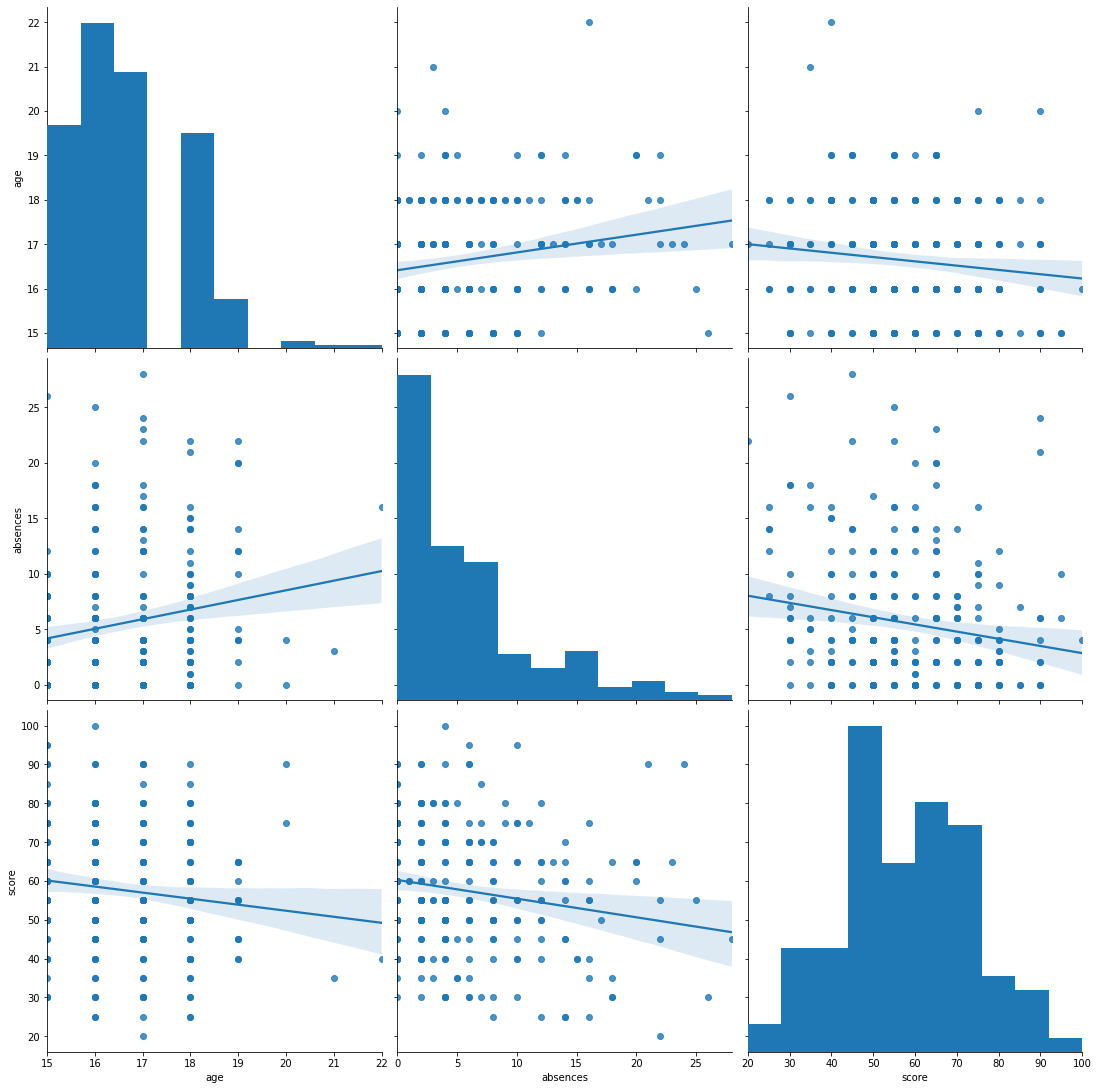

In [24]:
sns.pairplot(df, kind = 'reg',  x_vars=numeric_columns, y_vars= numeric_columns, height=5)

As we can see, all columns are correlated with the `score` column.

Let's check values of columns correlation:

In [25]:
df.corr()['score']
df.corr()['score'].abs().sort_values(ascending=False)

age          -0.122720
Medu          0.182008
Fedu          0.135784
traveltime   -0.086525
studytime     0.145942
famrel        0.052929
freetime     -0.015550
goout        -0.182649
health       -0.038964
absences     -0.176336
score         1.000000
Name: score, dtype: float64

score         1.000000
goout         0.182649
Medu          0.182008
absences      0.176336
studytime     0.145942
Fedu          0.135784
age           0.122720
traveltime    0.086525
famrel        0.052929
health        0.038964
freetime      0.015550
Name: score, dtype: float64

Nothing unexpected there: 
 - Skipping school(`absences`) is bad. 
 - Spend time for rest(`goout`) and studying(`studytime`) is good. 
 - High school students are lazy(`age`).
 - Parents education matters(`Medu`, `Fedu`). We will check this again in the nominal variable checking section.
 - Travel time a has negative impact on the score.
 
Health and family relationships are not such important as I've expected.

Free time brings almost nothing to the final results.

I think that sugnificatnt numeric parameters are:

In [26]:
significant_numeric_columns = ['age', 'absences']

There are a lot of interesting observations that can be extracted from full correlation matrix:

In [27]:
df.corr()

,age,Medu,Fedu,traveltime,studytime,famrel,freetime,goout,health,absences,score
age,1.000000,-0.125813,-0.144709,0.081692,-0.016507,0.046969,-0.013862,0.077844,-0.053247,0.186320,-0.122720
Medu,-0.125813,1.000000,0.633608,-0.174026,0.079801,-0.018546,-0.014301,0.071604,-0.083394,0.118875,0.182008
Fedu,-0.144709,0.633608,1.000000,-0.182231,-0.018427,-0.025128,-0.026050,0.022215,0.001357,0.022504,0.135784
traveltime,0.081692,-0.174026,-0.182231,1.000000,-0.117565,-0.057736,0.011071,0.010225,0.012005,-0.032003,-0.086525
studytime,-0.016507,0.079801,-0.018427,-0.117565,1.000000,0.038864,-0.120283,-0.041135,-0.106093,-0.081077,0.145942
famrel,0.046969,-0.018546,-0.025128,-0.057736,0.038864,1.000000,0.149971,0.038430,0.131320,-0.094024,0.052929
freetime,-0.013862,-0.014301,-0.026050,0.011071,-0.120283,0.149971,1.000000,0.268816,0.105258,0.017851,-0.015550
goout,0.077844,0.071604,0.022215,0.010225,-0.041135,0.038430,0.268816,1.000000,-0.006449,0.095603,-0.182649
health,-0.053247,-0.083394,0.001357,0.012005,-0.106093,0.131320,0.105258,-0.006449,1.000000,-0.048198,-0.038964
absences,0.186320,0.118875,0.022504,-0.032003,-0.081077,-0.094024,0.017851,0.095603,-0.048198,1.000000,-0.176336


 - Amount of absences are not coupled with health.
 - A parents's education provides a positive impact,  but a father's one provides a negative impact on many parameters.
 - Good family relationships produce a positive impact on health and amount of freee time.
 - and many many more...


## Nominal columns


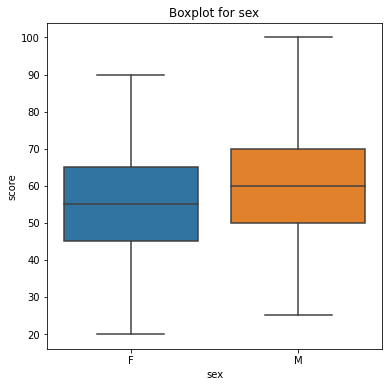

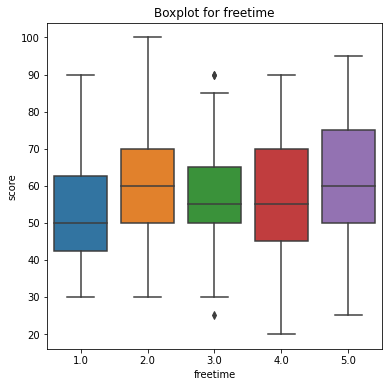

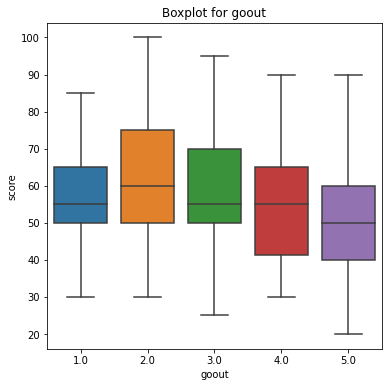

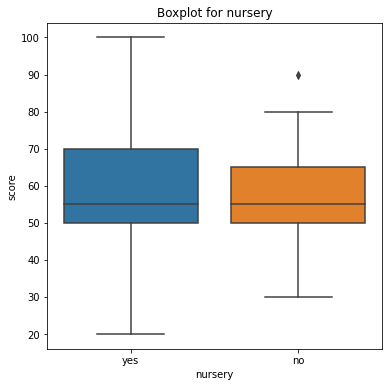

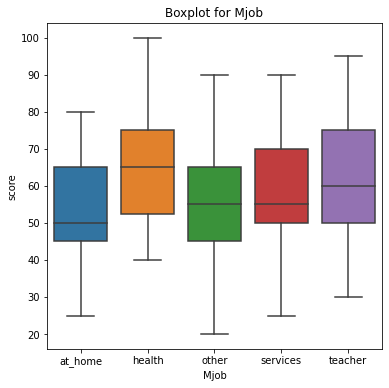

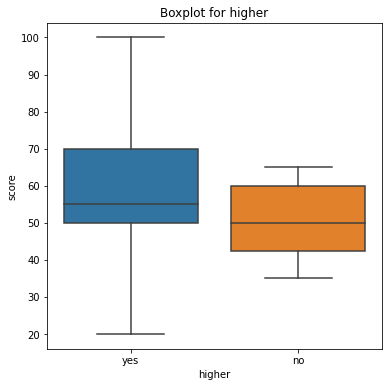

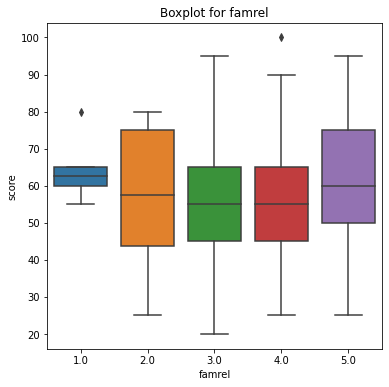

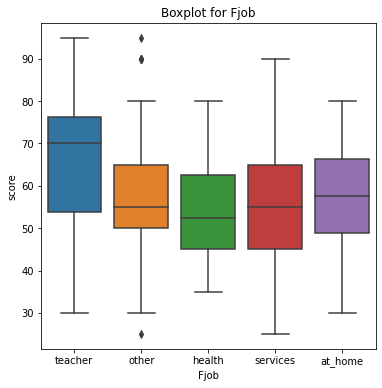

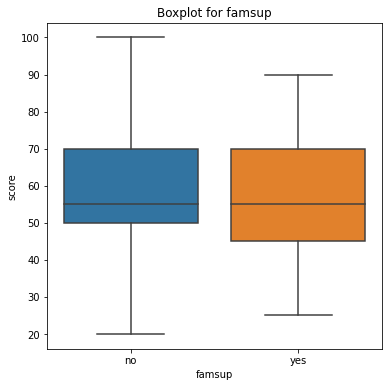

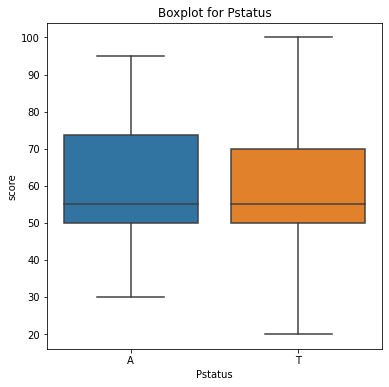

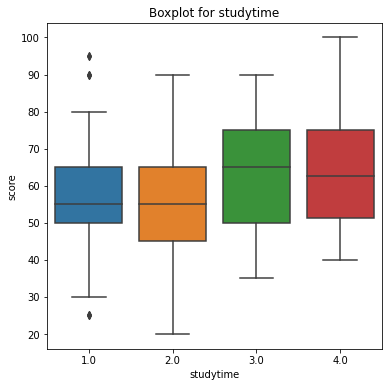

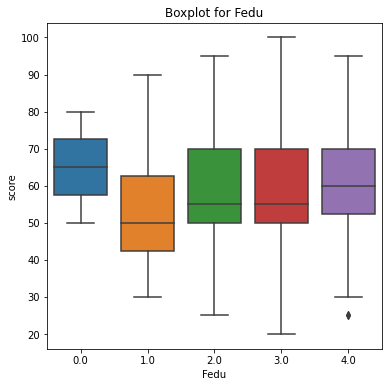

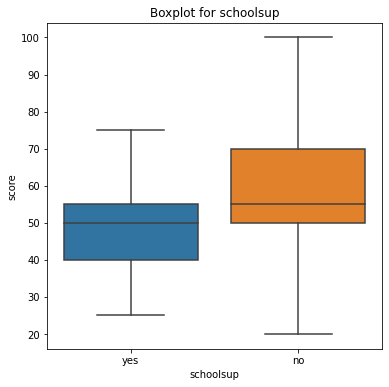

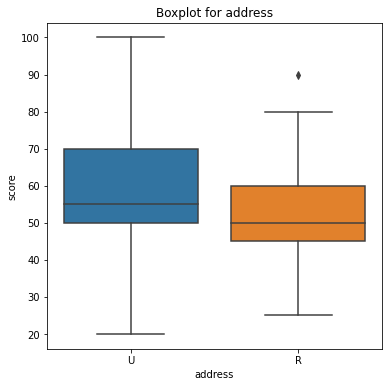

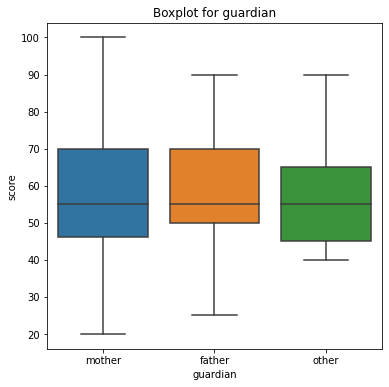

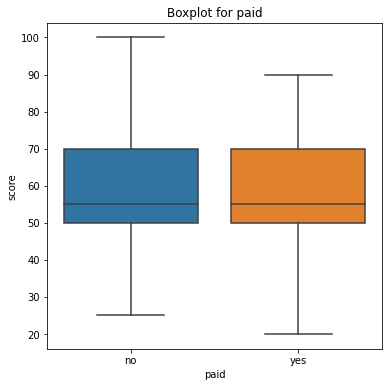

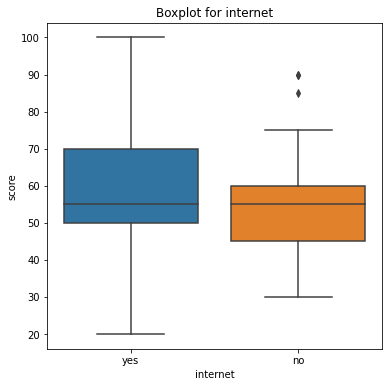

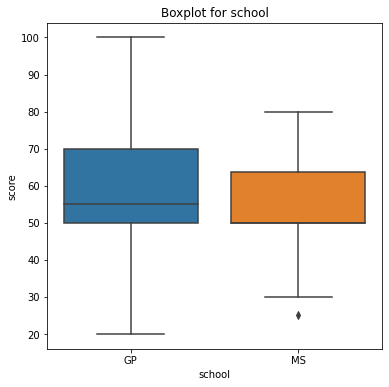

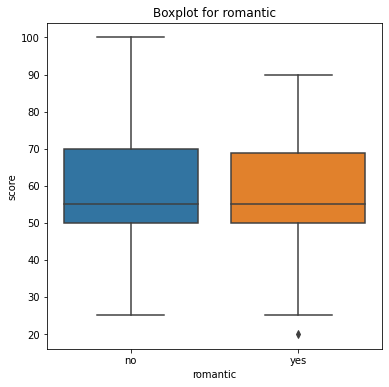

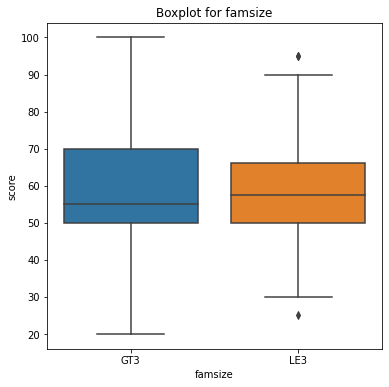

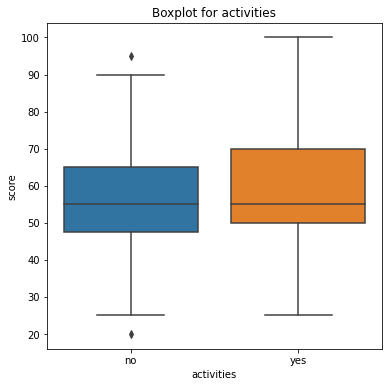

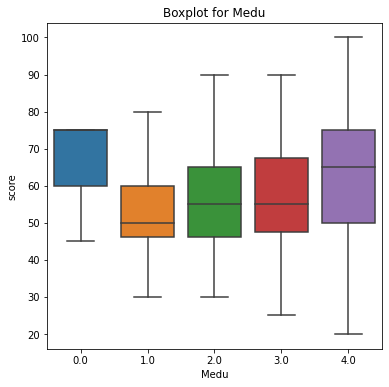

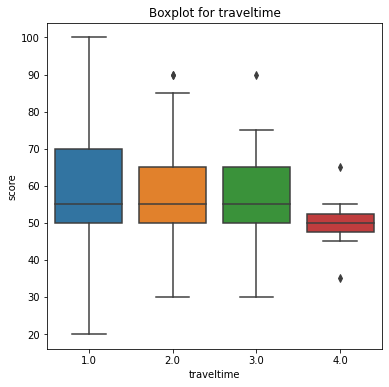

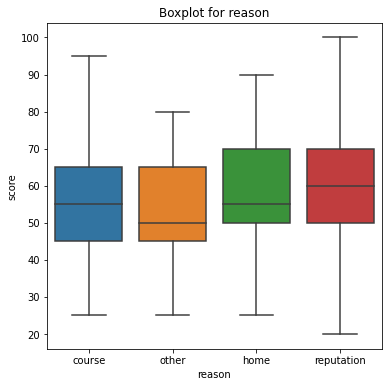

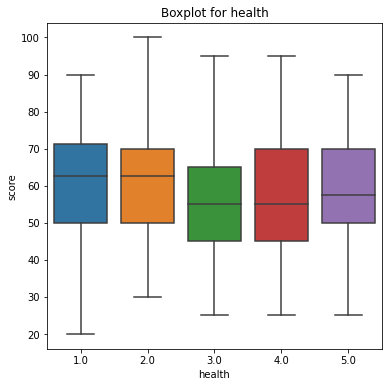

In [28]:
for col in nominal_columns:
    get_boxplot(col, df)

In [29]:
significant_nominal_columns = list(filter(lambda col: is_stat_dif(col, df, 0.05), nominal_columns))
significant_nominal_columns

['goout', 'Mjob', 'studytime', 'schoolsup', 'address', 'Medu']

## Summary

Now we can build dataset for our model. It contains following columns:
 - `score`
 - significant_numeric_columns
 - significant_nominal_columns

In [30]:
significant_columns = set(['score'] + significant_numeric_columns+significant_nominal_columns)
stud_math = df.loc[:, significant_columns]
stud_math.head()
stud_math.info()

,address,age,goout,Mjob,absences,Medu,studytime,score,schoolsup
0,U,18,4.0,at_home,6.0,4.0,2.0,30.0,yes
1,U,17,3.0,at_home,4.0,1.0,2.0,30.0,no
2,U,15,2.0,at_home,10.0,1.0,2.0,50.0,yes
3,U,15,2.0,health,2.0,4.0,3.0,75.0,no
4,U,16,2.0,other,4.0,3.0,2.0,50.0,no


<class 'pandas.core.frame.DataFrame'>
Int64Index: 292 entries, 0 to 394
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   address    282 non-null    object 
 1   age        292 non-null    int64  
 2   goout      286 non-null    float64
 3   Mjob       276 non-null    object 
 4   absences   292 non-null    float64
 5   Medu       290 non-null    float64
 6   studytime  287 non-null    float64
 7   score      292 non-null    float64
 8   schoolsup  283 non-null    object 
dtypes: float64(5), int64(1), object(3)
memory usage: 32.8+ KB
